# Saviheng Universe 616

In this project we aim to analyze a graph made by characters and teams from the [Marvel Earth-616](https://marvel.fandom.com/wiki/Earth-616). Being the main Marvel universe it has a lot of different characters and teams (30021 differnet characters).

![header](../images/marvel616.webp)

The aim is to offer some undertanding of the ralationships inside this vast universe and try to get meaningful information from it.

The data is obtained from the [official marver wiki](https://marvel.fandom.com/wiki/Marvel_Database).

## Imports

What would be of a project without some imports ;).

In [71]:
# For API queries
import urllib
import json

# For fancy looking loops
from tqdm.notebook import tqdm

# Data manipulation
import pandas as pd

# For transforming to literal value instead of string ("[a, b, c]" => ["a", "b", "c"])
import ast

# For os operations (duh)
import os

# Small file that have useful functions
import utils

# For multithreading
from concurrent.futures import ThreadPoolExecutor, as_completed

# For regex operations
import re

# For sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# For plot visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For wordclouds
from wordcloud import WordCloud

# For natural language processing
import nltk

# For graph building
import networkx as nx

# For numeric transformations and operations
import numpy as np

# For calculating the powerlaw
import powerlaw

# For more iterating tools
import itertools

In [2]:
# So tqdm works with pandas
tqdm.pandas()

# Cool default plots
sns.set()

## Teams

We will start by analyzing and getting information from the teams. For that we use `Category:Earth-616/Teams`, from the wiki as it is where the teams are. Unfortunatly, it is not the only place that information is. We realized that superhero teams, such as the **Avengers**, are not actually a team, but an organization, so we need to use `Category:Earth-616/Organizations` too.

The function is quite lengthy, and maybe a bit convoluted, so we try to explain it as clearly as possible (note that the all the steps are repeated for `Teams` and `Organizatio`):

The query we do is something like:

```
https://marvel.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Earth-616/GROUP&prop=revisions&rvprop=content&rvslots=*&format=json&cmlimit=max&cmcontinue=CONTINUE_CODE"
```

I know it is very long, but it has some key values: `list=categorymembers`, which retursn all elements that belong to a category, in this case `Team` or `Organization`, and `cmcontinue=CONTINUE_CODE`, which allows us to do a for loop over multiple querys, as all the teams do not fit in the 500 limit the query has. Because we do not know how many there are, a `while` loop is needed.

In [3]:
def get_teams():
  
  cmcontinue_text = ""
  first_time = True
  
  team_list = []
  
  while cmcontinue_text or first_time: 
  
    first_time = False
  
    baseurl = "https://marvel.fandom.com/api.php?"
    action = "action=query&list=categorymembers"
    q_title = "cmtitle=Category:Earth-616/Teams"

    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    cmcontinue = "cmlimit=max&cmcontinue={}".format(cmcontinue_text)

    query = "{}{}&{}&{}&{}&{}".format(baseurl, action, q_title, content, dataformat, cmcontinue)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    
    wiki_json = json.loads(wikitext)
    
    team_list += [team["title"] for team in wiki_json["query"]["categorymembers"]
                 if not team["title"].startswith("Category:")]
    
    if "continue" in list(wiki_json.keys()):
      cmcontinue_text = wiki_json["continue"]["cmcontinue"]
    else:
      cmcontinue_text = ""
      
  first_time = True
    
  while cmcontinue_text or first_time: 
  
    first_time = False
  
    baseurl = "https://marvel.fandom.com/api.php?"
    action = "action=query&list=categorymembers"
    q_title = "cmtitle=Category:Earth-616/Organizations"

    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    cmcontinue = "cmlimit=max&cmcontinue={}".format(cmcontinue_text)

    query = "{}{}&{}&{}&{}&{}".format(baseurl, action, q_title, content, dataformat, cmcontinue)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    
    wiki_json = json.loads(wikitext)
    
    team_list += [team["title"] for team in wiki_json["query"]["categorymembers"]
                 if not team["title"].startswith("Category:")]
    
    if "continue" in list(wiki_json.keys()):
      cmcontinue_text = wiki_json["continue"]["cmcontinue"]
    else:
      cmcontinue_text = ""
      
  return team_list

Now, with the massive function, we can get all the teams.

In [4]:
teams = list(set(get_teams()))
print(f"There are {len(teams)} teams.")

There are 3054 teams.


### Getting members

Now that we have all our teams, we need to get the members of each team.  Luckily, there is a special page where we can get that: `Category:TEAM_NAME/Members`.

The query is very similar to the previous one: 

```
https://marvel.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:TEAM_NAME/Members&rop=revisions&rvprop=content&rvslots=*&format=json&cmlimit=max&cmcontinue=CONTINUE_CODE
```

Which works pretty much the same as the previous one.

The only remark is that, for some reason, some teams have 'members' that are actually references to files, so we do not append any character taht starts with the keyword `File:`.

In [5]:
def getMembers(team):  
  cmcontinue_text = ""
  first_time = True
  
  member_list = []
  
  while cmcontinue_text or first_time: 
  
    first_time = False
  
    baseurl = "https://marvel.fandom.com/api.php?"
    action = "action=query&list=categorymembers"
    q_title = "cmtitle=Category:{}/Members".format(urllib.parse.quote_plus(team.replace(" ", "_")))

    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    cmcontinue = "cmlimit=max&cmcontinue={}".format(cmcontinue_text)

    query = "{}{}&{}&{}&{}&{}".format(baseurl, action, q_title, content, dataformat, cmcontinue)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    
    wiki_json = json.loads(wikitext)
    
    member_list += [member["title"]
                    for member in wiki_json["query"]["categorymembers"]
                    if not member["title"].startswith("File:")]
    
    if "continue" in list(wiki_json.keys()):
      cmcontinue_text = wiki_json["continue"]["cmcontinue"]
    else:
      cmcontinue_text = ""
      
  return member_list

The next operation is quite lenghty, so if you have the dataframe already, press enter without input.

In [6]:
answer = input("Do you want to get the members of the team? ")

if answer:
  dataset = []
  for team in tqdm(teams):
    dataset.append([team, getMembers(team)])

  df = pd.DataFrame(dataset, columns=["team_name", "members"])
  df.to_csv("../data/marvel_teams.csv", index=False)
else:
  df = pd.read_csv("../data/marvel_teams.csv")
  df["members"] = df["members"].apply(ast.literal_eval)
  
df

Do you want to get the members of the team? 


team_name  \
0                            Oracle Inc. (Earth-616)   
1                         Metal Mobsters (Earth-616)   
2      Knights of the Atomic Round Table (Earth-616)   
3                                             Yoruba   
4           Emissaries of Evil (Electro) (Earth-616)   
...                                              ...   
3046                       Junkyard Dogs (Earth-616)   
3047           S.H.I.E.L.D. Psi Division (Earth-616)   
3048                             Crusade (Earth-616)   
3049  Fraternity of Raptors (Warp World) (Earth-616)   
3050               Serpent Squad (Cobra) (Earth-616)   

                                                members  
0     [Anita Savvy (Earth-616), Caleb Alexander (Ear...  
1                                                    []  
2     [Anthony Stark (Earth-616), Bruce Banner (Eart...  
3                                                    []  
4     [Manuel Eloganto (Earth-616), Maxwell Dillon (...  
...                                                 ...  
3046                  [Rashid Hammer Jones (Earth-616)]  
3047  [Agent Locke (Earth-616), Daniel Fricks (Earth...  
3048                           [Ezra Keith (Earth-616)]  
3049                                                 []  
3050  [Jordan Dixon (Earth-616), Klaus Voorhees (Ear...  

[3051 rows x 2 columns]

### Information from members

Cool, now that we have the members of each team, we can start doing fancy stuff. Let's start by getting how many members each team has, and let's check the top 10 teams with more members.

In [7]:
df["number_members"] = df["members"].apply(len)

df.sort_values("number_members", ascending=False).reset_index(drop=True).head(10)

team_name  \
0  Strategic Homeland Intervention, Enforcement a...   
1        New York City Police Department (Earth-616)   
2  National Socialist German Workers Party (Earth...   
3                     United States Army (Earth-616)   
4                                  Hydra (Earth-616)   
5                    50-State Initiative (Earth-616)   
6                Advanced Idea Mechanics (Earth-616)   
7                                  X-Men (Earth-616)   
8                       Stark Industries (Earth-616)   
9                  Daily Bugle (The DB!) (Earth-616)   

                                             members  number_members  
0  [Abigail Brand (Earth-616), Abner Jenkins (Ear...             640  
1  [Al Farrell (Earth-616), Alan Greene (Earth-61...             577  
2  [Admiral von Roeder (Earth-616), Adolf Hitler ...             405  
3  [101st Airborne Division (Earth-616), 82nd Air...             395  
4  [Aaron Nicholson (Earth-616), Adi (Earth-616),...             282  
5  [Aaron Stack (Impostor) (Earth-616), Abigail B...             245  
6  [A-14 (Earth-616), A.I.Monkeys (Earth-616), Ab...             196  
7  [Akihiro (Earth-616), Alani Ryan (Earth-616), ...             186  
8  [Abraham Klein (Earth-616), Abraham Zimmer (Ea...             146  
9  [Abe Benerstein (Earth-616), Abner Abernathy (...             146

Ok, this is useful, and quite unexpected. The team with the second most members is not a superhero team, but a police department, and not only that, but the third one is the nazi german party, and fourth the US army.

Well, it makes sense, as each of those have, or had, a lot of real life members, that probably make appearances in the comics, and thus are in the wiki.

Let's try to see how many different characters there are in total in our dataset right now.

In [8]:
len_diff_char = len(list(set(df['members'].sum())))

print(f"There are {len_diff_char} different characters.")
print(f"What means there are around {30021 - len_diff_char} characters that do not belong to any team.")

There are 12298 different characters.
What means there are around 17723 characters that do not belong to any team.


To make the network an analysis more manageable, we will only work with those characters that belongs to, at least, one team.

Well, let's try to see more data from our teams. We can start with a bit of fancy analysis. We can try to do some sentiment analysis. For that, we can use the quotes of each of the characters of a team, but that can get messy if we do it multiple times for each character (as one character can belong to multiple teams), so let's try to create a character dataframe, and come back to the sentiment analysis for the teams for later.

## Characters

### Create dataframe

The first step is to create the dataframe, with all the characters and to wich teams they belong to.

In [9]:
all_characters = []
for _, row in df.iterrows():
  for member in row["members"]:
    all_characters += [(member, row["team_name"])]
    
print(f"Number of characters: {len(all_characters)}")

Number of characters: 19148


With each character with the team they belong too, we can do a `groupby`, and get all the teams in a list. And easily get how many teams does each character belongs to.

Let's check the top ten character that belong to more teams.

In [10]:
df_char = pd.DataFrame(all_characters, columns=["name", "team"])

df_char = df_char.groupby("name")["team"].progress_apply(list).to_frame("teams").reset_index()
df_char["number_teams"] = df_char["teams"].progress_apply(len)

df_char.sort_values("number_teams", ascending=False).reset_index(drop=True).head(10)

  0%|          | 0/12298 [00:00<?, ?it/s]

  0%|          | 0/12298 [00:00<?, ?it/s]

name  \
0    James Howlett (Earth-616)   
1     Peter Parker (Earth-616)   
2    Anthony Stark (Earth-616)   
3     Ororo Munroe (Earth-616)   
4      Henry McCoy (Earth-616)   
5      Wade Wilson (Earth-616)   
6    Carol Danvers (Earth-616)   
7  Anthony Masters (Earth-616)   
8  Raven Darkholme (Earth-616)   
9   Clinton Barton (Earth-616)   

                                               teams  number_teams  
0  [Swordbearers of Krakoa (Earth-616), Clan Yash...            31  
1  [Frightful Four (Earth-616), Daily Bugle (Fron...            31  
2  [Knights of the Atomic Round Table (Earth-616)...            26  
3  [Quiet Council of Krakoa (Earth-616), Swordbea...            25  
4  [X-Factor (Earth-616), Acolytes (Earth-616), X...            24  
5  [Frightful Four (Earth-616), Agency X (Earth-6...            24  
6  [Kree/Skrull Alliance (Earth-616), 50-State In...            23  
7  [Frightful Four (Earth-616), Trenchcoat Mafia ...            23  
8  [Quiet Council of Krakoa (Earth-616), X-Factor...            23  
9  [Avengers Idea Mechanics (Earth-616), Black Ca...            23

As expected, most of those characters are pretty famous (in order: Wolverine, Spider-Man, Iron Man, Storm, Beast, Deadpool, Captain Marvel, Taskmaster, Mystique and Hawkeye).


### Quotes 

We are now going to get the quotes for all the characters.

The code is quite messy, and difficult to read, but the idea behind it is that we use multiple threadsd to download the content faster.

The query we do is:

```
https://marvel.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:CHARACTER/Quotes&prop=revisions&rvprop=content&rvslots=*&format=json&cmlimit=max&cmcontinue=CONTINUE_CODE
```

Which again, works similar to those already seen.

In [11]:
quote_path = "../data/character_quotes/"

def get_character_quotes(name: str):
  # This is a little bit hacky, but works
  cmcontinue_text = ""
  quote_titles = []

  # Breaks when there are no more cm_continues
  while True:
    baseurl = "https://marvel.fandom.com/api.php?"
    args = {
      "action"      : "action=query&list=categorymembers",
      "q_title"     : "cmtitle=Category:{}/Quotes".format(urllib.parse.quote_plus(name.replace(" ", "_"))),
      "content"     : "prop=revisions&rvprop=content&rvslots=*",
      "dataformat"  : "format=json",
      "cmcontinue"  :  "cmlimit=max&cmcontinue={}".format(cmcontinue_text),
    }
    
    query = f"{baseurl}{'&'.join(args.values())}"

    wikiresponse = urllib.request.urlopen(query)
    wikitext = wikiresponse.read().decode('utf-8')
    wiki_json = json.loads(wikitext)
    
    quote_titles += [page["title"] for page in wiki_json["query"]["categorymembers"]]

    if "continue" in list(wiki_json.keys()):
      cmcontinue_text = wiki_json["continue"]["cmcontinue"]
    else: break
  
  quote_title_chunks = utils.generate_chunks(quote_titles)
  quotes = []

  for chunk in quote_title_chunks:
    quote_data = search_quotes(chunk)
    for content in quote_data["query"]["pages"].values():
      content  = content["revisions"][-1]["slots"]["main"]["*"]
      quotes += re.findall(r"Quotation.*?= (.*?)\n", content)
  
  filename = utils.generate_filename(name)
  with open(f"{quote_path}{filename}.json", "w") as f:
    json.dump(quotes, f, indent = 4)

def get_chunk_quotes(chunk: list):
  for name in chunk:
    get_character_quotes(name)
  return

def get_quotes(names: list, max_workers=16):
  files = set(os.listdir(quote_path))
  missing_names = list(
    filter(lambda x: f"{utils.generate_filename(x)}.json" not in files,
    names)
  )

  if len(missing_names) == 0:
    print("No missign quotes found 😊")
    return
  
  chunks = utils.generate_chunks(missing_names)
  print (f"Generated {len(chunks)} chunks!")
  with tqdm(total=len(chunks)) as pbar:
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
      futures = [ex.submit(get_chunk_quotes, chunk)
                  for chunk in chunks]
      for future in as_completed(futures):
        pbar.update(1)


get_quotes(df_char["name"].values , max_workers=24)

Generated 7 chunks!


  0%|          | 0/7 [00:00<?, ?it/s]

Now we have succesfully downloaded all quotes, we are going to load them in the characters dataset, and display the top 10 characters with most quotes.

In [12]:
def getQuotes(row):
  quotes = None
  try:
    with open("../data/character_quotes/"+utils.generate_filename(row["name"])+".json") as f:
      quotes = ast.literal_eval(f.read())
  except:
    quotes = []
  
  return pd.Series([quotes, len(quotes)])


df_char[["quotes", "number_quotes"]] = df_char.progress_apply(getQuotes, axis=1)

df_char.sort_values("number_quotes", ascending=False).reset_index(drop=True).head(10)

  0%|          | 0/12298 [00:00<?, ?it/s]

name  \
0     Peter Parker (Earth-616)   
1    Steven Rogers (Earth-616)   
2    Anthony Stark (Earth-616)   
3    James Howlett (Earth-616)   
4      Wade Wilson (Earth-616)   
5     Bruce Banner (Earth-616)   
6     Thor Odinson (Earth-616)   
7  Matthew Murdock (Earth-616)   
8  Stephen Strange (Earth-616)   
9   Benjamin Grimm (Earth-616)   

                                               teams  number_teams  \
0  [Frightful Four (Earth-616), Daily Bugle (Fron...            31   
1  [Invaders (WWII) (Earth-616), United States Ar...            17   
2  [Knights of the Atomic Round Table (Earth-616)...            26   
3  [Swordbearers of Krakoa (Earth-616), Clan Yash...            31   
4  [Frightful Four (Earth-616), Agency X (Earth-6...            24   
5  [Knights of the Atomic Round Table (Earth-616)...            22   
6  [Axis (Avengers) (Earth-616), Circus of Crime ...            13   
7  [Defenders (Earth-616), Marvel Knights (Earth-...             8   
8  [Defenders (Earth-616), Avengers (Earth-616), ...            11   
9  [50-State Initiative (Earth-616), Fantastic Th...            19   

                                              quotes  number_quotes  
0  [Adoma. Congratulations. You just became the f...            666  
1  [They should be proud to have her as a student...            432  
2  [There's only two things I ever managed to bel...            381  
3  [There ain't no sense to it, babe. There's nev...            337  
4  [It's an angel of God. My glorious Bea Arthur-...            287  
5  [The '''angrier''' I get the '''stronger''' I ...            227  
6  ['''Alfheim.''' Realm of the [[Light Elves|Elv...            215  
7  [The name's Daredevil... remember it! You'll b...            203  
8  [[[Bellona (The Sisters) (Earth-616)|This one]...            182  
9  [It's Clobberin' Time!, Let's see if I can liv...            173

Again, most of the most famous characters have the most quotes, being Spider_man the one with the most.

## Back with teams

### Quotes

Now that we have the quotes, we are going to give get the quotes per team, and display the top ten with most quotes.

In [13]:
def getQuotes(row):
  quotes = []
  for member in row["members"]:
    try:
      with open("../data/character_quotes/"+member.replace(" ", "_")+".json") as f:
        quotes += ast.literal_eval(f.read())
    except:
      quotes += []
  
  return pd.Series([quotes, len(quotes)])


df[["quotes", "number_quotes"]] = df.progress_apply(getQuotes, axis=1)

df.sort_values("number_quotes", ascending=False).reset_index(drop=True).head(10)

  0%|          | 0/3051 [00:00<?, ?it/s]

team_name  \
0                               Avengers (Earth-616)   
1  Strategic Homeland Intervention, Enforcement a...   
2                                  X-Men (Earth-616)   
3                       Secret Defenders (Earth-616)   
4                           New Avengers (Earth-616)   
5                Avengers Unity Division (Earth-616)   
6                    50-State Initiative (Earth-616)   
7                              Defenders (Earth-616)   
8            Secret Avengers (Civil War) (Earth-616)   
9                         Fantastic Four (Earth-616)   

                                             members  number_members  \
0  [Aaron Stack (Earth-616), Abyss (Ex Nihilo's) ...             115   
1  [Abigail Brand (Earth-616), Abner Jenkins (Ear...             640   
2  [Akihiro (Earth-616), Alani Ryan (Earth-616), ...             186   
3  [Aleksei Sytsevich (Earth-616), Anthony Druid ...              32   
4  [Anthony Stark (Earth-616), Barbara Morse (Ear...              18   
5  [Alexander Summers (Earth-616), Emily Guerrero...              22   
6  [Aaron Stack (Impostor) (Earth-616), Abigail B...             245   
7  [Alani Ryan (Earth-616), Aleta Ogord (Earth-69...              62   
8  [Aaron Stack (Impostor) (Earth-616), Bonita Ju...              50   
9  [Bast (Earth-616), Benjamin Grimm (Earth-616),...              27   

                                              quotes  number_quotes  
0  [Gangway, ladies and gentlemen of this sun-soa...           5038  
1  [Okay, this is a ludicrously high-tech gun so ...           3867  
2  [I never knew my father. I was raised... to be...           3743  
3  [I'm Rhino. I knock things down. That's what I...           2989  
4  [There's only two things I ever managed to bel...           2906  
5  [[[X-Factor (Government) (Earth-TRN566)|We've]...           2615  
6  [Out of respect for our past friendship, [[Wil...           2297  
7  [I <b>told</b> you... We're X-Men. We <b>impro...           2206  
8  [Out of respect for our past friendship, [[Wil...           2195  
9  [In Necropolis.  The Wakandan City of the dead...           2038

It is not impressive that the team with most quotes is the Avengers, as is one of the biggest and most famous teams.

Now that each team has it quotes, we can do some text analaysis. For example, we can start with how many words, unique words and lexical richness each team has.

For that, first, the links, all `\n` symbols and any non alphabetical characters are going to be removed from the quotes. And lastly, the additional spaces.

We are going to display the top 10 teams with more than 500 unique words with the highest lexical richness.

In [14]:
def getLexicalRichness(row):
  regex_links = r"(?:\{\{.*?\}\}|\[\[.*?\]\])"
  regex_newline = r"\\n"
  regex_no_alpha = r"[^a-zA-Z ]"
  regex_aditional_space = r"\s\s+"
  
  text = " ".join(row["quotes"])
  text = re.sub(regex_links, "", text)
  text = re.sub(regex_newline, " ", text)
  text = re.sub(regex_no_alpha, " ", text)
  text = re.sub(regex_aditional_space, " ", text)
  
  words = [word for word in text.lower().split(" ") if len(word) > 1]
  
  number_words = len(words)
  number_unique_words = len(list(set(words)))
  lexical_richness = 0
  
  if number_words > 0:
    lexical_richness = number_unique_words/number_words
  return pd.Series([number_words, number_unique_words, lexical_richness])

df[["number_words",
    "number_unique_words",
    "lexical_richness"]] = df.progress_apply(getLexicalRichness, axis=1)

df[df["number_unique_words"] > 500].sort_values("lexical_richness", ascending=False)\
                                   .reset_index(drop=True).head(10)

  0%|          | 0/3051 [00:00<?, ?it/s]

team_name  \
0                                Hex-Men (Earth-616)   
1    Stark Industries Board of Directors (Earth-616)   
2                                Rejects (Earth-616)   
3                      Brand Corporation (Earth-616)   
4                        Exemplars Squad (Earth-616)   
5         Department of Occult Armaments (Earth-616)   
6                              Argonauts (Earth-616)   
7                          Olympus Group (Earth-616)   
8           Office of National Emergency (Earth-616)   
9  Defense Advanced Research Projects Agency (Ear...   

                                             members  number_members  \
0  [Henry McCoy (Earth-616), Kurt Wagner (Earth-9...               4   
1  [Eric Lynch (Earth-616), Henry McCoy (Earth-616)]               2   
2  [Agrom (Earth-616), Boomer (Reject) (Earth-616...              11   
3  [Anton Miguel Rodriquez (Earth-616), Carl Madd...              14   
4  [Angel Salvadore (Earth-616), Henry McCoy (Ear...               2   
5  [Alizon Baunacha (Earth-616), Ananym (Earth-61...              32   
6  [Atalanta (Argonauts) (Earth-616), Augeas (Ear...              10   
7  [Amadeus Cho (Earth-616), Arachne (Earth-616),...              17   
8  [Alexander Lexington (Earth-616), Demetrius La...               9   
9  [Clayton Wilson (Earth-616), Forge (Earth-616)...               4   

                                              quotes  number_quotes  \
0  [I'm not your X-Man Professor... I'm my own ma...             75   
1  [I'm not your X-Man Professor... I'm my own ma...             75   
2  [I'm not your X-Man Professor... I'm my own ma...             75   
3  [Thanks to [[Mason Sackett (Earth-616)|your fa...             88   
4  [Like we're '''ever''' gonna win anything in '...             78   
5  [Ah, '''Wildheart...''' how wonderfully '''per...             53   
6  ["Tis of little import how '''long''' one live...             67   
7  [Hang on! [[Isaac Ikeda (Earth-616)|Who]] -- w...             65   
8  [Pray for me, Reverend. It looks like I'm gonn...             69   
9  [Why don't you call me by my proper name --- F...             68   

   number_words  number_unique_words  lexical_richness  
0        1264.0                597.0          0.472310  
1        1264.0                597.0          0.472310  
2        1264.0                597.0          0.472310  
3        1413.0                650.0          0.460014  
4        1399.0                633.0          0.452466  
5        1146.0                502.0          0.438045  
6        1375.0                598.0          0.434909  
7        1364.0                592.0          0.434018  
8        1204.0                515.0          0.427741  
9        1353.0                567.0          0.419069

We can do even more interesting stuff, such as sentiment analysis per team. We are going to use VADER sentiment analysis to get the average feeling of each team.

In [15]:
def getVaderSentiment(row):
  sid_obj = SentimentIntensityAnalyzer()
  
  happy = []
  sad = []
  neutral = []
  compound = []
  category = []
  
  for quote in row["quotes"]:
    sentiment_dict = sid_obj.polarity_scores(quote)
    happy.append(sentiment_dict["pos"])
    sad.append(sentiment_dict["neg"])
    neutral.append(sentiment_dict["neu"])
    compound.append(sentiment_dict["compound"])
    
    if sentiment_dict['compound'] >= 0.05:
        category.append("Positive")
 
    elif sentiment_dict['compound'] <= - 0.05:
        category.append("Negative")
 
    else:
        category.append("Neutral")
  if len(row["quotes"]) == 0:
    return pd.Series([0, 0, 0, 0, "Neutral"])
  
  happy_val = sum(happy)/len(happy)
  sad_val = sum(sad)/len(sad)
  neutral_val = sum(neutral)/len(neutral)
  compound_val = sum(compound)/len(compound)
  category_val = max(category, key=category.count)
  return pd.Series([happy_val*100, sad_val*100, neutral_val*100, compound_val, category_val])
    

df[["%happy",
   "%sad",
   "%neutral",
   "compound_sentiment",
   "overall_category"]] = df.progress_apply(getVaderSentiment, axis=1)

  0%|          | 0/3051 [00:00<?, ?it/s]

Now we can display the top 10 happier teams, and top 10 saddest, among those with at least 500 unqieu words (based on compound value).

In [16]:
df[df["number_unique_words"] > 500].sort_values("compound_sentiment", ascending=False)\
                                   .reset_index(drop=True).head(10)

team_name  \
0                      Centerville Globe (Earth-616)   
1               Patsy Walker Enterprises (Earth-616)   
2                      Alaska Initiative (Earth-616)   
3                         Avengers World (Earth-616)   
4               Patsy Walker Temp Agency (Earth-616)   
5              Brotherhood of the Shield (Earth-616)   
6  Law Offices of Jennifer Walters, PLLC (Earth-616)   
7  Avengers Artificial Intelligence Squad (Earth-...   
8                           Superior Six (Earth-616)   
9                     Horizon University (Earth-616)   

                                             members  number_members  \
0  [Hedy Wolfe (Earth-616), Minerva Potts (Earth-...               6   
1  [Al Hartley (Earth-616), Beatrice Walker (Eart...              10   
2                      [Patricia Walker (Earth-616)]               1   
3  [Adam Brashear (Earth-616), Aikku Jokinen (Ear...              11   
4  [Bailey (Earth-616), Federigo Ravina (Earth-61...               5   
5  [Aaron Stack (Impostor) (Earth-616), Abu Mūsā ...              23   
6  [Angie Huang (Earth-616), Hei Hei (Earth-616),...               4   
7  [Alexis (Earth-616), Doombot (Avenger) (Earth-...               7   
8  [Adrian Toomes (Earth-616), Dmitri Smerdyakov ...               6   
9  [Anna Maria Marconi (Earth-616), Aribella Fish...               7   

                                              quotes  number_quotes  \
0  [But of course, I don't like to '''brag''' abo...             85   
1  [But of course, I don't like to '''brag''' abo...             93   
2  [The Beast owes me and I plan to collect!, Tur...             71   
3  [I don't believe it -- even here -- [[Luna (Mo...             52   
4  [I have a magical bag that can store infinite ...            107   
5  [Out of respect for our past friendship, [[Wil...            105   
6  [What's the matter, [[Janet Van Dyne (Earth-61...            184   
7  [[[Dimitrios (Earth-616)|Dimitrios]] is coming...            118   
8  [I fought '''[[Matthew Murdock (Earth-616)|Dar...             98   
9  [Wow. Moving kind of fast, aren't we [[Otto Oc...             78   

   number_words  number_unique_words  lexical_richness     %happy       %sad  \
0        1542.0                599.0          0.388457  16.965882   6.870588   
1        1651.0                631.0          0.382193  15.807527   6.422581   
2        1261.0                520.0          0.412371  17.045070   7.518310   
3        1674.0                522.0          0.311828  11.988462   6.682692   
4        1868.0                714.0          0.382227  15.472897   7.871028   
5        2744.0                766.0          0.279155  12.909524  10.198095   
6        3556.0               1079.0          0.303431  13.965761   8.242935   
7        3494.0               1017.0          0.291070  11.218644   8.455085   
8        2492.0                814.0          0.326645  14.371429   9.098980   
9        2101.0                742.0          0.353165  14.412821   8.567949   

    %neutral  compound_sentiment overall_category  
0  76.165882            0.263309         Positive  
1  77.772043            0.244825         Positive  
2  75.439437            0.235380         Positive  
3  81.319231            0.178115         Positive  
4  76.656075            0.164204         Positive  
5  76.890476            0.152648         Positive  
6  77.792935            0.136615         Positive  
7  80.324576            0.133664         Positive  
8  75.506122            0.133040         Positive  
9  75.734615            0.132794         Positive

In [17]:
df[df["number_unique_words"] > 500].sort_values("compound_sentiment", ascending=True)\
                                   .reset_index(drop=True).head(10)

team_name  \
0                       Quentin Carnival (Earth-616)   
1                   Spirits of Vengeance (Earth-616)   
2                   Nine (Midnight Sons) (Earth-616)   
3                     Legion of Monsters (Earth-616)   
4           National Force (Hate-Monger) (Earth-616)   
5                    Geraci Crime Family (Earth-616)   
6                              New X-Men (Earth-616)   
7  National Socialist German Workers Party (Earth...   
8                                Maroons (Earth-616)   
9                             Taifa Ngao (Earth-616)   

                                             members  number_members  \
0  [Aura-Lee (Earth-616), Bart Slade (Earth-616),...              26   
1  [Alejandra Jones (Earth-616), Alejandra Jones ...              47   
2  [Daniel Ketch (Earth-616), Eric Brooks (Earth-...               9   
3  [Elsa Bloodstone (Earth-616), Frank Castle (Ea...              13   
4  [Frank Castle (Earth-616), Hate-Monger (Nation...               2   
5  [Frank Castle (Earth-616), Horace Halftree (Ea...              10   
6  [Cessily Kincaid (Earth-616), David Alleyne (E...              12   
7  [Admiral von Roeder (Earth-616), Adolf Hitler ...             405   
8                             [T'Challa (Earth-616)]               1   
9  [Akili (Earth-616), Cangza (Earth-616), Everet...              10   

                                              quotes  number_quotes  \
0  [Rash fools! They believe me a mere human! The...             75   
1  ['''Silence!''' Do you hear them? Hundreds of ...             57   
2  [I fought my share of psychos as '''[[Ghost Ri...            156   
3  [Why must doing the right bloody thing be '''s...            294   
4  [I kill only those who '''deserve''' killing, ...            148   
5  [I kill only those who '''deserve''' killing, ...            148   
6  [[[Julian Keller (Earth-616)|Julian]], one of ...             89   
7  [Der bigger der lie you tell, der more chance ...            105   
8  [Do you think you're the first person that eve...            109   
9  [[[Mephisto (Earth-616)|You]] ever been on Jer...            123   

   number_words  number_unique_words  lexical_richness    %happy       %sad  \
0        1534.0                585.0          0.381356  6.726667  21.288000   
1        1426.0                522.0          0.366059  8.100000  17.563158   
2        3236.0                955.0          0.295117  8.229487  17.464103   
3        6043.0               1553.0          0.256992  9.434014  15.080272   
4        3069.0                960.0          0.312805  9.588514  13.689865   
5        3069.0                960.0          0.312805  9.588514  13.689865   
6        2177.0                627.0          0.288011  7.498876  12.770787   
7        1953.0                742.0          0.379928  9.187619  14.539048   
8        2433.0                762.0          0.313194  7.597248  12.016514   
9        2747.0                843.0          0.306880  7.151220  11.522764   

    %neutral  compound_sentiment overall_category  
0  70.650667           -0.367953         Negative  
1  72.582456           -0.274811         Negative  
2  73.026923           -0.252849         Negative  
3  74.803401           -0.194328         Negative  
4  76.041892           -0.175436         Negative  
5  76.041892           -0.175436         Negative  
6  79.735955           -0.166934         Negative  
7  76.276190           -0.153852         Negative  
8  80.387156           -0.146381         Negative  
9  81.326829           -0.141767         Negative

### WordClouds

After this brief sentiment analysis, we can try to do the cool wordclouds :). We are going to display the wordclouds of the top 20 teams with the most number of unique words.

For that first we need to preprocess the quotes. Firts, we are going to remove the links, then the `\n` and not alphabetical numbers. Then remove additional spaces, and set all the words to lower.

In [18]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pheithar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pheithar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
wnl = nltk.WordNetLemmatizer()

def preprocessQuotes(row):
  processed_quotes = []
  
  regex_links = r"(?:\{\{.*?\}\}|\[\[.*?\]\])"
  regex_newline = r"\\n"
  regex_no_alpha = r"[^a-zA-Z ]"
  regex_aditional_space = r"\s\s+"
  
  for quote in row["quotes"]:
    quote = re.sub(regex_links, " ", quote)
    quote = re.sub(regex_newline, " ", quote)
    quote = re.sub(regex_no_alpha, " ", quote)
    quote = re.sub(regex_aditional_space, " ", quote)
    
    tokens = tokenizer.tokenize(quote)
    
    all_words = [x.strip().lower() for x in tokens]
    
    stop_words = list(nltk.corpus.stopwords.words("english")) # Stopwords
    
    filtered = [x for x in all_words if x not in stop_words]
    
    lemmatized = [wnl.lemmatize(w) for w in filtered]
    
    new_stopwords = ["im", "one", "earth", "know", "im", "b", "u"]
    
    lemmatized = [x for x in lemmatized if x not in new_stopwords]
    
    processed_quotes.append(lemmatized)
  
  return processed_quotes

df["processed_quotes"] = df.progress_apply(preprocessQuotes, axis=1)

  0%|          | 0/3051 [00:00<?, ?it/s]

Then with the processed quotes, we can display the wordclouds.

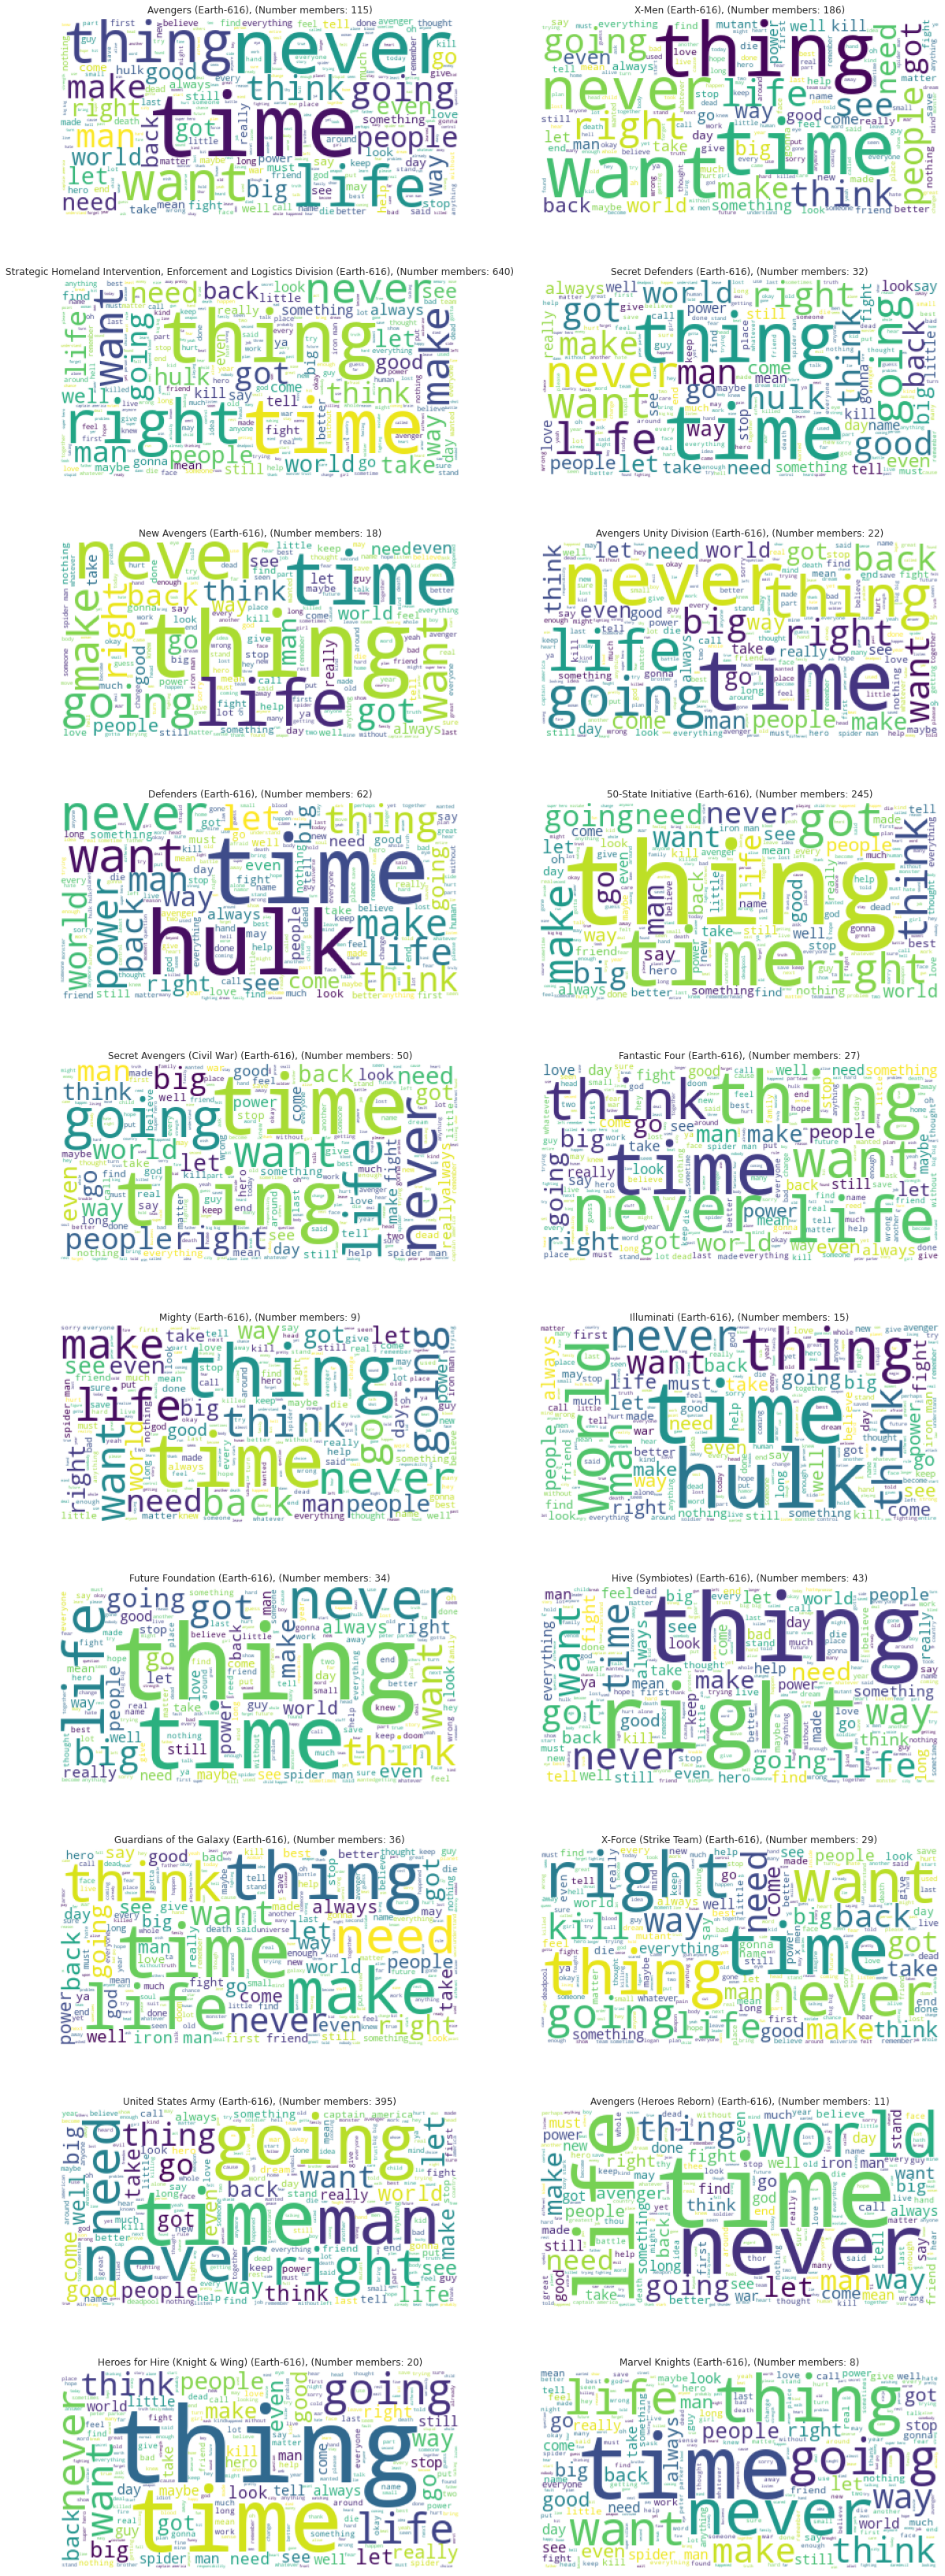

In [20]:
fig, axarr = plt.subplots(10, 2, figsize=(20, 60))

df_quotes = df.sort_values("number_unique_words", ascending=False)

word_cloud = WordCloud(max_words=2000,
                       background_color="white"
                      )

for i, ax in enumerate(axarr.flatten()):
  content = " ".join(word
                     for quote in df_quotes.iloc[i, 13]
                     for word in quote)
  ax.imshow(word_cloud.generate(content))
  ax.axis("off")
  ax.set_title(f"{df_quotes.iloc[i, 0]}, (Number members: {df_quotes.iloc[i, 2]})")

plt.show()

From these wordclouds we can see a clear result. Either all of those teams share one specific theme (`thing`, `time`, `going`...), or all share a couple of characters that make take most of the quotes. Either way, it is not giving too much information.

### Graph

Now the moment of truth is here. It is time to build the graph. We are going to join two teams if they share at least one member. So the first step is, obviously, get wich teams share a member. For that, we can use the previously build `df_char`, dataframe of characters. We can check which ones are the top ten most connected teams.

In [21]:
def getConnections(row):
  connections = []
  
  df_char_row = df_char[df_char["name"].isin(row["members"])]
    
  for _, row_char in df_char_row.iterrows():
    if row["team_name"] in row_char["teams"]:
      connections += row_char["teams"]
      connections.remove(row["team_name"])
      
  connections = list(set(connections))
  
  return pd.Series([connections, len(connections)])

df[["connections", "number_connections"]] = df.progress_apply(getConnections, axis=1)  

df.sort_values("number_connections", ascending=False).reset_index(drop=True).head(10)

  0%|          | 0/3051 [00:00<?, ?it/s]

team_name  \
0  Strategic Homeland Intervention, Enforcement a...   
1                    50-State Initiative (Earth-616)   
2                               Avengers (Earth-616)   
3                                  X-Men (Earth-616)   
4                           Thunderbolts (Earth-616)   
5                     United States Army (Earth-616)   
6                                  Hydra (Earth-616)   
7                          Hellfire Club (Earth-616)   
8                              Defenders (Earth-616)   
9                       Secret Defenders (Earth-616)   

                                             members  number_members  \
0  [Abigail Brand (Earth-616), Abner Jenkins (Ear...             640   
1  [Aaron Stack (Impostor) (Earth-616), Abigail B...             245   
2  [Aaron Stack (Earth-616), Abyss (Ex Nihilo's) ...             115   
3  [Akihiro (Earth-616), Alani Ryan (Earth-616), ...             186   
4  [Abner Jenkins (Earth-616), Ajaxis (Earth-616)...             100   
5  [101st Airborne Division (Earth-616), 82nd Air...             395   
6  [Aaron Nicholson (Earth-616), Adi (Earth-616),...             282   
7  [Adrienne Frost (Earth-616), Alan Wilson (Eart...             123   
8  [Alani Ryan (Earth-616), Aleta Ogord (Earth-69...              62   
9  [Aleksei Sytsevich (Earth-616), Anthony Druid ...              32   

                                              quotes  number_quotes  \
0  [Okay, this is a ludicrously high-tech gun so ...           3867   
1  [Out of respect for our past friendship, [[Wil...           2297   
2  [Gangway, ladies and gentlemen of this sun-soa...           5038   
3  [I never knew my father. I was raised... to be...           3743   
4  [Oh, get real, would you? I've got all the wea...           1005   
5  [If we have erred, [[Steven Rogers (Earth-616)...           1353   
6  [Okay people, gather around -- we're just abou...            670   
7  [But I feel it's time I went back to the state...           1155   
8  [I <b>told</b> you... We're X-Men. We <b>impro...           2206   
9  [I'm Rhino. I knock things down. That's what I...           2989   

   number_words  number_unique_words  lexical_richness     %happy       %sad  \
0       77674.0               7313.0          0.094150  10.371037  10.022601   
1       47826.0               5623.0          0.117572  10.962821   9.676186   
2      110880.0               8821.0          0.079554  10.828523   9.817983   
3       86278.0               7549.0          0.087496  10.603767  10.296180   
4       21963.0               3416.0          0.155534  10.917313   9.233234   
5       27044.0               3978.0          0.147094  10.697044   8.854028   
6       14473.0               2863.0          0.197817  10.320000  11.535970   
7       26302.0               3791.0          0.144134  10.514459  10.481732   
8       47831.0               5679.0          0.118731  10.704578  10.744787   
9       63429.0               6466.0          0.101941  10.442824  10.417832   

    %neutral  compound_sentiment overall_category  \
0  79.270701           -0.000218         Positive   
1  78.970919            0.025500         Positive   
2  78.878047            0.023882         Positive   
3  78.753914           -0.002799         Positive   
4  78.756716            0.016832         Positive   
5  80.227347            0.036651         Positive   
6  77.097015           -0.064540         Negative   
7  78.487013           -0.013678         Negative   
8  77.871442           -0.003427         Negative   
9  78.571529           -0.009568         Negative   

                                    processed_quotes  \
0  [[okay, ludicrously, high, tech, gun, anything...   
1  [[respect, past, friendship, maintain, sanctua...   
2  [[gangway, lady, gentleman, sun, soaked, isle,...   
3  [[never, knew, father, raised, someone, differ...   
4  [[oh, get, real, would, got, weaponry, fighter...   
5  [[erred, dead, within, second, drinking, ever,.

Once we have to whom each team connects, we can build the graph

In [22]:
def getEdges(row):
  edges = []
  for connection in row["connections"]:
    edges.append([row["team_name"], connection])
  
  return edges

team_graph = nx.Graph()

team_graph.add_nodes_from(df["team_name"])

all_edges = df.progress_apply(getEdges, axis=1)

for edges in all_edges:
  team_graph.add_edges_from(edges)


print(f"The team graph has {len(team_graph.nodes)} nodes and {len(team_graph.edges)} edges.")

  0%|          | 0/3051 [00:00<?, ?it/s]

The team graph has 3051 nodes and 15009 edges.


Now we can show multiple graph properties.

In [23]:
print("Graph basic stats:")
print(f"\tNumber of nodes: {len(team_graph.nodes)}")
print(f"\tNumber of edges: {len(team_graph.edges)}")
print(f"\tAverage degree: {sum(x[1] for x in team_graph.degree)/len(team_graph.degree):.2f}")
print()
print(f"\tMost connected node: {max(team_graph.degree, key=lambda x: x[1])[0]} \
with a degree of {max(team_graph.degree, key=lambda x: x[1])[1]}")

Graph basic stats:
	Number of nodes: 3051
	Number of edges: 15009
	Average degree: 9.84

	Most connected node: Strategic Homeland Intervention, Enforcement and Logistics Division (Earth-616) with a degree of 432


And we ccan reduce the size by getting only the Giant Connected Component (GCC)

In [24]:
team_graph_gcc = team_graph.subgraph(max(nx.connected_components(team_graph), key=len))

print(f"The team graph GCC has {len(team_graph_gcc.nodes)} nodes and {len(team_graph_gcc.edges)} edges.")

The team graph GCC has 1381 nodes and 14917 edges.


From this GCC, we can plot the degree distribution and check if it is random, or if it follows a powerlaw distribution.

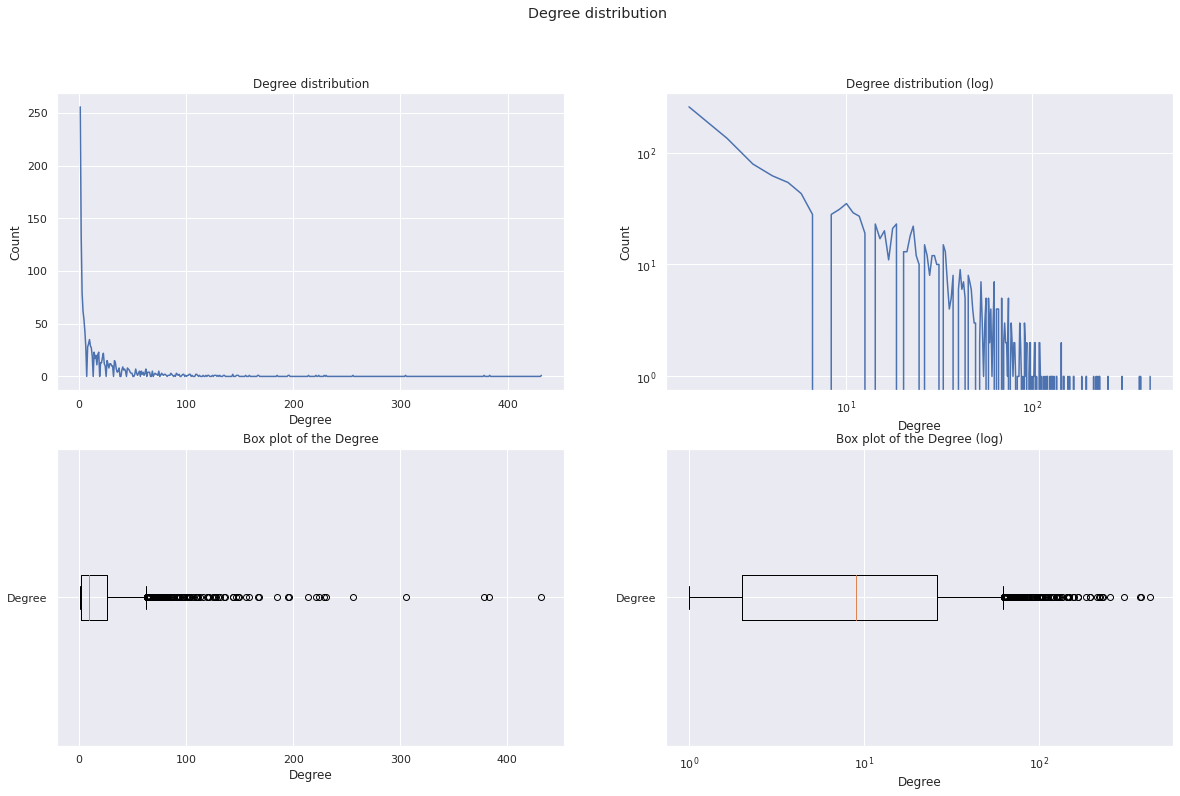

In [25]:
fig, ((ax, l_ax), (ax_bp, ax_bp_l)) = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle("Degree distribution")

degrees = dict(team_graph_gcc.degree()).values()

hist, bins = np.histogram(np.array(list(degrees)), bins=500)
center = (bins[:-1] + bins[1:])/2


ax.plot(center, hist)
ax.set_title("Degree distribution")
ax.set_xlabel("Degree")
ax.set_ylabel("Count")

l_ax.plot(center, hist)
l_ax.set_title("Degree distribution (log)")
l_ax.set_xlabel("Degree")
l_ax.set_ylabel("Count")
l_ax.set_xscale("log")
l_ax.set_yscale("log")

ax_bp.boxplot(degrees, vert=False, labels=["Degree"])
ax_bp.set_title("Box plot of the Degree")
ax_bp.set_xlabel("Degree")

ax_bp_l.boxplot(degrees, vert=False, labels=["Degree"])
ax_bp_l.set_title("Box plot of the Degree (log)")
ax_bp_l.set_xlabel("Degree")
ax_bp_l.set_xscale("log")

plt.show()

It does look like a powerlaw distribution, where a few nodes have a high degree while the majority of nodes only have a couple connections, but we need to prove it.

In [41]:
results = powerlaw.Fit(list(degrees))
print(f"The alpha of the degree dinstribution is: {results.power_law.alpha}")

Calculating best minimal value for power law fit
The alpha of the degree dinstribution is: 3.38718295333891


The alpha is $>1$, so this network belongs to the **Superlinear Regime** which means that, on top of not being a random networks, it has a few disproportionaly atractive nodes, which group most of the data.

### Wiki content

Other metrics we can get from the data, is the lenght and content of their wikis. For that, first we need to get the content from them.

The query looks lisk:

```
http://marvel.fandom.com/api.php?action=query&prop=revisions&rvprop=content&rvslots=*&titles=TEAM_NAME&format=json
```

Again the function is a bit long, but is done this way so we can do multithreading.

In [99]:
content_path = "../data/team_content/"

links  = re.compile(r"\[\[(.*?)(?:\|.*?)?\]\]")


def get_team_content(names):
    # Querying wiki for name
    base_url = "http://marvel.fandom.com/api.php?"
    action = "action=query"
    title = f"titles={'|'.join([urllib.parse.quote_plus(name.replace(' ', '_')) for name in names])}"
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"

    query = "{}{}&{}&{}&{}".format(base_url, action, content, title, dataformat)
    
    resp = urllib.request.urlopen(query)
    text = resp.read().decode("utf-8")
    data = json.loads(text)
    
    pages = data["query"]["pages"]
    for page_id, page in pages.items():
        page["page_id"] = page_id
        filename = utils.generate_filename(page["title"])
        
        with open(f"{content_path}{filename}.json", "w") as f:
            json.dump(page, f, indent=4)

def get_team_info(name, all_names_set):
    filename = utils.generate_filename(name)
    data = json.loads(open(f"{content_path}{filename}.json", "r").read())

    content = data["revisions"][0]["slots"]["main"]["*"]
    
    return content

# Multithreaded solution for faster speed
def get_content(names, max_workers = 16):
    files = set(os.listdir(content_path))
    missing_names = list(
        filter(lambda x: f"{utils.generate_filename(x)}.json" not in files,
        names
        ))

    if len(missing_names) == 0:
        print("No missing names found 😊")
        return
        
    chunks = utils.generate_chunks(missing_names)
    print(f"Generated {len(chunks)} chunks!")
    with tqdm(total=len(chunks)) as pbar:
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            futures = [ex.submit(get_team_content, chunk) 
                       for chunk in chunks]
            for future in as_completed(futures):
                pbar.update(1)
    print("Done downloading files!")

def get_teams_infos(names, max_workers = 16):
    all_names_set = set(names)
    infos = []
    with tqdm(total=len(names)) as pbar:
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            for result in ex.map(get_team_info, names, itertools.repeat(all_names_set)):
                infos.append(result)
                pbar.update(1)
    print("Done getting character information")
    return infos

In [100]:
get_content(df["team_name"])

No missing names found 😊


In [98]:
df["wiki_content"] = get_teams_infos(df["team_name"])
df.head()

  0%|          | 0/3051 [00:00<?, ?it/s]

Done getting character information


team_name  \
0                        Oracle Inc. (Earth-616)   
1                     Metal Mobsters (Earth-616)   
2  Knights of the Atomic Round Table (Earth-616)   
3                                         Yoruba   
4       Emissaries of Evil (Electro) (Earth-616)   

                                             members  number_members  \
0  [Anita Savvy (Earth-616), Caleb Alexander (Ear...              10   
1                                                 []               0   
2  [Anthony Stark (Earth-616), Bruce Banner (Eart...               6   
3                                                 []               0   
4  [Manuel Eloganto (Earth-616), Maxwell Dillon (...               5   

                                              quotes  number_quotes  \
0  [Now I can take my father's place -- as an Inv...            169   
1                                                 []              0   
2  [There's only two things I ever managed to bel...            922   
3                                                 []              0   
4  [I have defeated the most deadly toros in a th...             26   

   number_words  number_unique_words  lexical_richness     %happy       %sad  \
0        3798.0               1088.0          0.286467  10.242604  11.622485   
1           0.0                  0.0          0.000000   0.000000   0.000000   
2       20080.0               3215.0          0.160110  10.702711  11.686226   
3           0.0                  0.0          0.000000   0.000000   0.000000   
4         504.0                233.0          0.462302  10.534615  10.130769   

    %neutral  compound_sentiment overall_category  \
0  78.133728           -0.048969         Negative   
1   0.000000            0.000000          Neutral   
2  77.396312           -0.014595         Negative   
3   0.000000            0.000000          Neutral   
4  75.476923            0.057392         Positive   

                                    processed_quotes  \
0  [[take, father, place, invader], [take, father...   
1                                                 []   
2  [[two, thing, ever, managed, believe, firstly,...   
3                                                 []   
4  [[defeated, deadly, toros, thousand, bull, fig...   

                                         connections  number_connections  \
0  [Braddock Academy (Earth-616), All-Winners Squ...                  34   
1                                                 []                   0   
2  [Axis (Avengers) (Earth-616), United States Hu...                  58   
3                                                 []                   0   
4  [Legion Accursed (Earth-616), Exterminators (S...                  13   

                                        wiki_content  
0  {{Marvel Database:Organization Template\n| Ima...  
1  {{Marvel Database:Team Template\n| Image      ...  
2  {{Marvel Database:Team Template\n| Image      ...  
3  {{Marvel Database:Organization Template\n| Ima...  
4  {{Marvel Database:Team Template\n| Image      ...

Once we have the wiki, we can, for example, get the number of words, number of unique words, lexical richeness and wordclouds of the top 20 teams whith most unique words.

In [101]:
def getLexicalRichnessWiki(row):
  regex_links = r"(?:\{\{.*?\}\}|\[\[.*?\]\])"
  regex_newline = r"\\n"
  regex_no_alpha = r"[^a-zA-Z ]"
  regex_aditional_space = r"\s\s+"
  
  text = " ".join(row["wiki_content"])
  text = re.sub(regex_links, "", text)
  text = re.sub(regex_newline, " ", text)
  text = re.sub(regex_no_alpha, " ", text)
  text = re.sub(regex_aditional_space, " ", text)
  
  words = [word for word in text.lower().split(" ") if len(word) > 1]
  
  number_words = len(words)
  number_unique_words = len(list(set(words)))
  lexical_richness = 0
  
  if number_words > 0:
    lexical_richness = number_unique_words/number_words
  return pd.Series([number_words, number_unique_words, lexical_richness])

df[["number_words_wiki",
    "number_unique_words_wiki",
    "lexical_richness_wiki"]] = df.progress_apply(getLexicalRichness, axis=1)

df[df["number_unique_words_wiki"] > 500].sort_values("lexical_richness_wiki", ascending=False)\
                                        .reset_index(drop=True).head(10)

  0%|          | 0/3051 [00:00<?, ?it/s]

team_name  \
0                                Hex-Men (Earth-616)   
1    Stark Industries Board of Directors (Earth-616)   
2                                Rejects (Earth-616)   
3                      Brand Corporation (Earth-616)   
4                        Exemplars Squad (Earth-616)   
5         Department of Occult Armaments (Earth-616)   
6                              Argonauts (Earth-616)   
7                          Olympus Group (Earth-616)   
8           Office of National Emergency (Earth-616)   
9  Defense Advanced Research Projects Agency (Ear...   

                                             members  number_members  \
0  [Henry McCoy (Earth-616), Kurt Wagner (Earth-9...               4   
1  [Eric Lynch (Earth-616), Henry McCoy (Earth-616)]               2   
2  [Agrom (Earth-616), Boomer (Reject) (Earth-616...              11   
3  [Anton Miguel Rodriquez (Earth-616), Carl Madd...              14   
4  [Angel Salvadore (Earth-616), Henry McCoy (Ear...               2   
5  [Alizon Baunacha (Earth-616), Ananym (Earth-61...              32   
6  [Atalanta (Argonauts) (Earth-616), Augeas (Ear...              10   
7  [Amadeus Cho (Earth-616), Arachne (Earth-616),...              17   
8  [Alexander Lexington (Earth-616), Demetrius La...               9   
9  [Clayton Wilson (Earth-616), Forge (Earth-616)...               4   

                                              quotes  number_quotes  \
0  [I'm not your X-Man Professor... I'm my own ma...             75   
1  [I'm not your X-Man Professor... I'm my own ma...             75   
2  [I'm not your X-Man Professor... I'm my own ma...             75   
3  [Thanks to [[Mason Sackett (Earth-616)|your fa...             88   
4  [Like we're '''ever''' gonna win anything in '...             78   
5  [Ah, '''Wildheart...''' how wonderfully '''per...             53   
6  ["Tis of little import how '''long''' one live...             67   
7  [Hang on! [[Isaac Ikeda (Earth-616)|Who]] -- w...             65   
8  [Pray for me, Reverend. It looks like I'm gonn...             69   
9  [Why don't you call me by my proper name --- F...             68   

   number_words  number_unique_words  lexical_richness     %happy       %sad  \
0        1264.0                597.0          0.472310  12.780000   8.668000   
1        1264.0                597.0          0.472310  12.780000   8.668000   
2        1264.0                597.0          0.472310  12.780000   8.668000   
3        1413.0                650.0          0.460014  12.369318   8.762500   
4        1399.0                633.0          0.452466  12.891026   8.758974   
5        1146.0                502.0          0.438045   8.339623  13.145283   
6        1375.0                598.0          0.434909  14.286567   9.404478   
7        1364.0                592.0          0.434018  12.121538  11.673846   
8        1204.0                515.0          0.427741  10.195652  10.588406   
9        1353.0                567.0          0.419069  11.604412   8.019118   

    %neutral  compound_sentiment overall_category  \
0  77.225333            0.094193         Positive   
1  77.225333            0.094193         Positive   
2  77.225333            0.094193         Positive   
3  77.737500            0.080830         Positive   
4  77.074359            0.094155         Positive   
5  78.516981           -0.140785         Negative   
6  74.814925            0.123696         Positive   
7  73.133846           -0.010506         Positive   
8  79.218841           -0.024762         Negative   
9  80.380882            0.076532         Positive   

                                    processed_quotes  \
0  [[x, man, professor, man, leave, alone], [tric...   
1  [[x, man, professor, man, leave, alone], [tric...   
2  [[x, man, professor, man, leave, alone], [tric...   
3  [[thanks, dead, legally, least, property, tiss...   
4  [[like, ever, gonna, win, anything, rotten, ex...   
5  [[ah, wildheart, wonderfully, perceptive, enti.

In [120]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
wnl = nltk.WordNetLemmatizer()

def preprocessWiki(row):
  regex_links = r"(?:\{\{.*?\}\}|\[\[.*?\]\])"
  regex_newline = r"\\n"
  regex_no_alpha = r"[^a-zA-Z ]"
  regex_aditional_space = r"\s\s+"
  
  content = row["wiki_content"]
  content = re.sub(regex_links, " ", content)
  content = re.sub(regex_newline, " ", content)
  content = re.sub(regex_no_alpha, " ", content)
  content = re.sub(regex_aditional_space, " ", content)

  tokens = tokenizer.tokenize(content)

  all_words = [x.strip().lower() for x in tokens]

  stop_words = list(nltk.corpus.stopwords.words("english")) # Stopwords

  filtered = [x for x in all_words if x not in stop_words]

  lemmatized = [wnl.lemmatize(w) for w in filtered]
  
  new_stopwords = ["im", "one", "earth", "know", "im", "b", "u",
                   "vol", "jpg", "template", "database", "h",
                   "e", "l", "title", "br"]

  lemmatized = [x for x in lemmatized if x not in new_stopwords]
  
  return lemmatized

df["processed_wiki"] = df.progress_apply(preprocessWiki, axis=1)

  0%|          | 0/3051 [00:00<?, ?it/s]

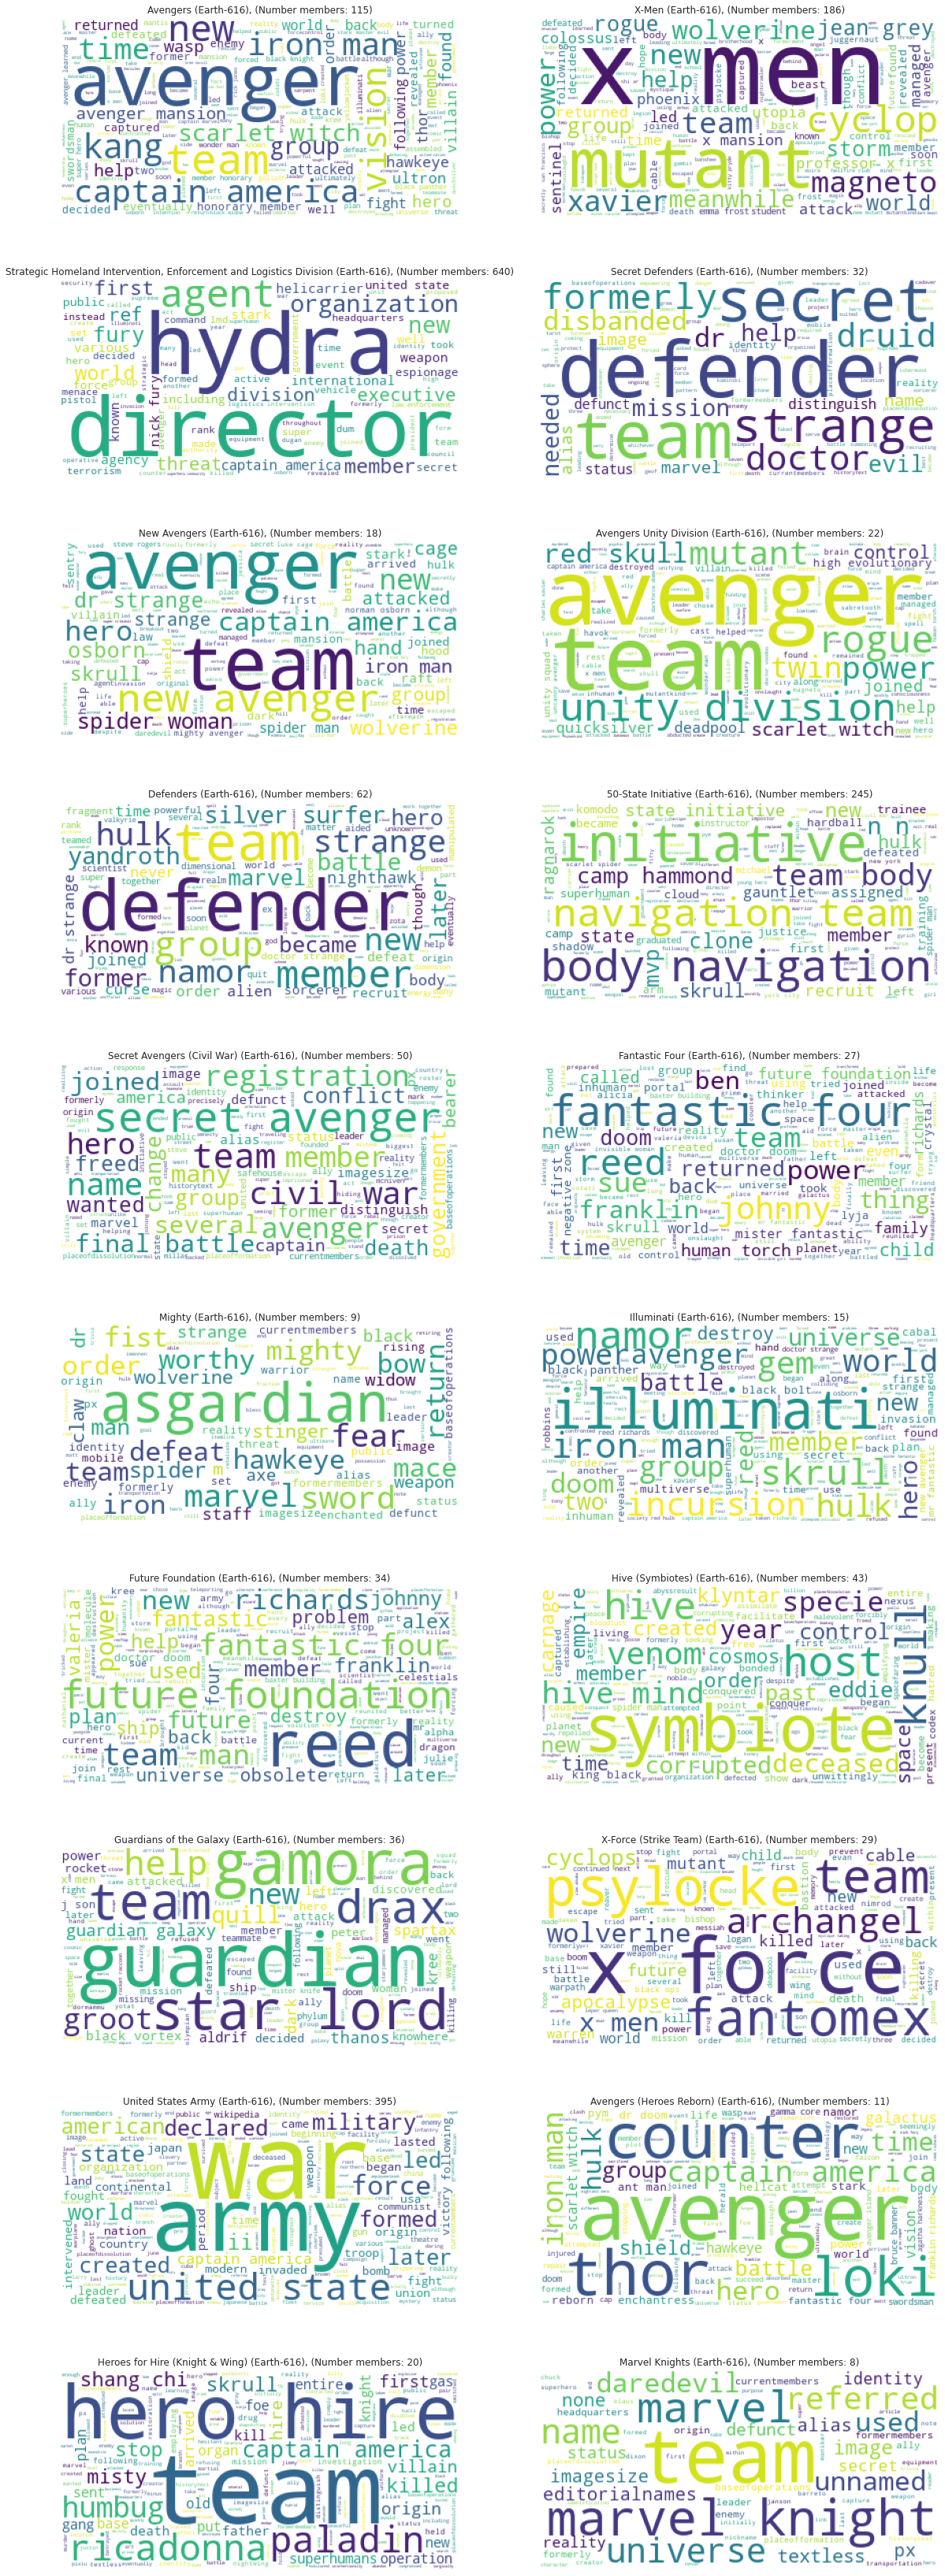

In [121]:
fig, axarr = plt.subplots(10, 2, figsize=(20, 60))

df_wiki = df.sort_values("number_unique_words_wiki", ascending=False)

word_cloud = WordCloud(max_words=2000,
                       background_color="white"
                      )

for i, ax in enumerate(axarr.flatten()):
  content = " ".join(df_wiki.iloc[i, 20])
  ax.imshow(word_cloud.generate(content))
  ax.axis("off")
  ax.set_title(f"{df_wiki.iloc[i, 0]}, (Number members: {df_wiki.iloc[i, 2]})")

plt.show()

### Correlation

We can try to do some quick analysis using the correlation between the different columns, to see, for example, if having more members translates to a longer wikipage, or if the more lexical richness the quotes have, the more lexical richness the wiki page will have. To display this information we can use a heatmap, that summarize all the correlations.

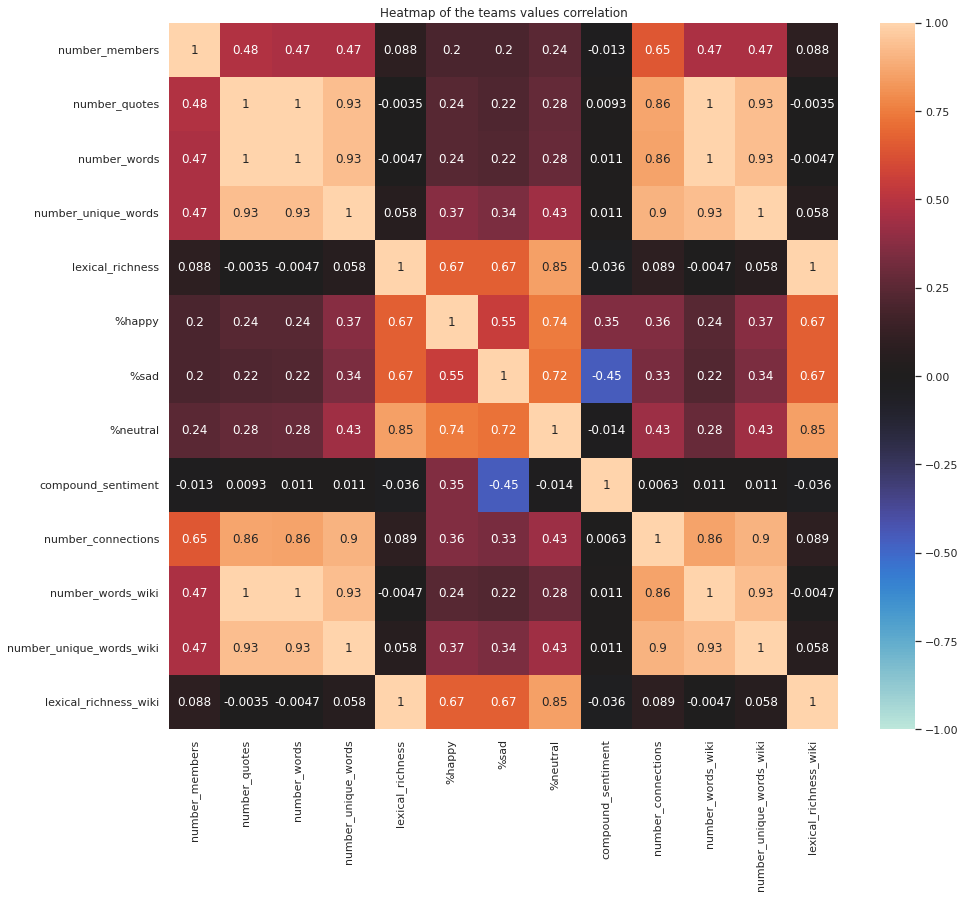

In [149]:
fix, ax = plt.subplots(figsize=(15, 13))

ax.set_title("Heatmap of the teams values correlation")

sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="icefire", ax=ax)

plt.show()

Yeah, we know, it is quite difficult to read, but here I can remark the most relevant results:

 - As expected, the **number of nodes** is highly correlated to the **number of connectios**, and is somehow related to the **number of quotes**, **number of words**, and **number of words in the wiki**.
 - Again, as expected, the **number of words** is higly correlated to the **number of unique words**, and **number of connections** and **number of unique words in the wiki**. 
 - **Lexical richness** is related to **happy**, **sad**, and specially, **neutral**, and to the **lexical richness** of the wiki.
 
## And back with characters

We have analyzed the 